# Visualization

In [1]:
from IPython.core.display import display, HTML
display(HTML("<st1yle>.container { width:100% !important; }</style>"))

import sys
sys.path.append('../../')

import numpy as np

from copy import deepcopy
from annotlib.standard import StandardAnnot


from src.models.beta_annotators_model import BAM
from src.query_strategies.multi_annotator_probabilistic_active_learning import xpal_gain
from src.utils.plot_functions import plot_scores_2d
from src.utils.data_functions import preprocess_2d_data_set
from src.utils.mathematical_functions import compute_vote_vectors
from src.base.data_set import DataSet
from src.query_strategies.multi_annotator_probabilistic_active_learning import MAPAL

from sklearn.metrics import pairwise_kernels

from matplotlib import rc
#rc('text', usetex=True)
#rc('font', family='serif')
rc('axes', edgecolor="black")

In this notebook, you can reproduce the annotation performance and instance utility plots by executing the cells below.
Remak: Before you can do this, you should have executed the notebook for simulating annotators.

In [2]:
def al_cylce(X, y, budgets, gamma, m_max=1, prior_mean=1, sum_prior=1, alpha=1, random_state=1):
    n_samples = len(X)
    n_annotators = y.shape[1]
    data_set = DataSet(X, n_annotators=n_annotators)
    annotators = StandardAnnot(X=X, Y=y)
    S = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    if sum_prior == 'mean':
        sum_prior = (np.sum(S)-n_samples)/(n_samples**2-n_samples)
    else:
        sum_prior = float(sum_prior)
    prior = np.array([prior_mean, 1 - prior_mean])
    prior *= sum_prior
    bam = BAM(n_classes=n_classes, metric='rbf', weights_type='entropy', gamma=gamma, prior=prior, random_state=random_state)
    query_strategy = MAPAL(data_set=data_set, n_classes=n_classes, m_max=m_max, S=S,
                           alpha_x=alpha, alpha_c=alpha, bam=bam, random_state=random_state)
    
    data_sets = []
    
    for b in range(1, np.max(budgets)+1):
        print("budget: {}".format(b))
        # select sample and annotator
        selection = query_strategy.make_query()
        sample_id = selection[0, 0]
        annotator_id = [selection[0, 1]]
        print("selected sample: {}".format(sample_id))
        print("selected annotator: {}".format(annotator_id))

        # query selected annotator for labeling selected sample
        X_query = [X[sample_id]]
        y_query = annotators.class_labels(X_query, annotator_ids=annotator_id)
        print('class label: {}'.format(y_query[0, annotator_id[0]]))

        # update training data
        data_set.update_entries(sample_id, y_query)
        
        if b in budgets:
            data_sets.append(deepcopy(data_set))
            
    
    return data_sets, prior

## Multi-annotator Probabilistic Active Learning (MaPAL)
You can adjust the parameters of MaPAL by chaning `m_max` and `beta_0`.

budget: 1
mean annotation performance values: [1. 1. 1. 1.]
#decision_flips: 90000
(263, 0)
selected sample: 263
selected annotator: [3]
class label: 1.0
budget: 2
mean annotation performance values: [1. 1. 1. 1.]
#decision_flips: 28441
(76, 0)
selected sample: 76
selected annotator: [0]
class label: 1.0
budget: 3
mean annotation performance values: [1. 1. 1. 1.]
#decision_flips: 20356
(27, 0)
selected sample: 27
selected annotator: [2]
class label: 0.0
budget: 4
mean annotation performance values: [1.         1.         0.80627883 0.73707869]
#decision_flips: 27867
(188, 0)
selected sample: 188
selected annotator: [1]
class label: 1.0
budget: 5
mean annotation performance values: [1.         1.         0.76929293 1.        ]
#decision_flips: 17527
(203, 0)
selected sample: 203
selected annotator: [1]
class label: 0.0
budget: 6
mean annotation performance values: [1.         1.         0.76929293 1.        ]
#decision_flips: 11018
(27, 0)
selected sample: 27
selected annotator: [0]
cla

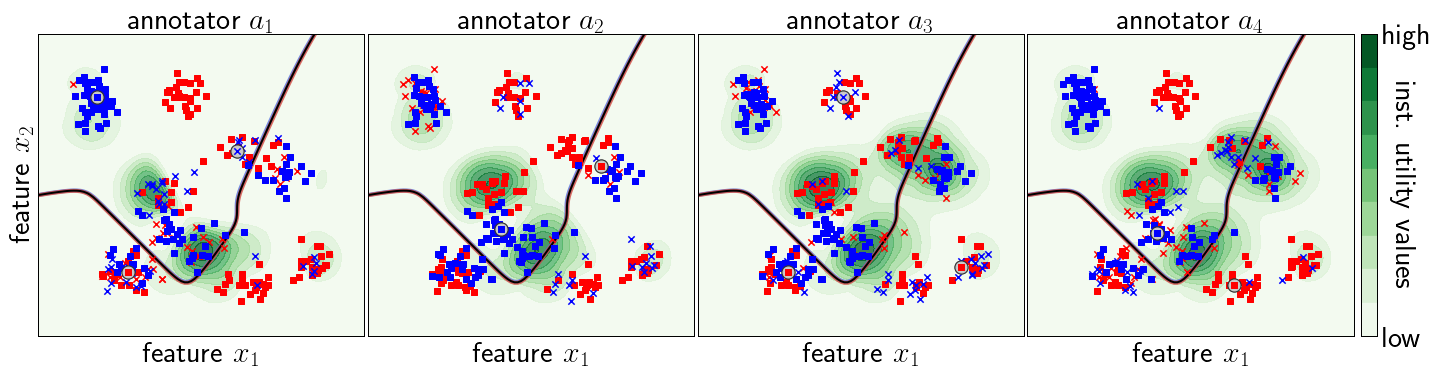

<Figure size 1728x864 with 0 Axes>

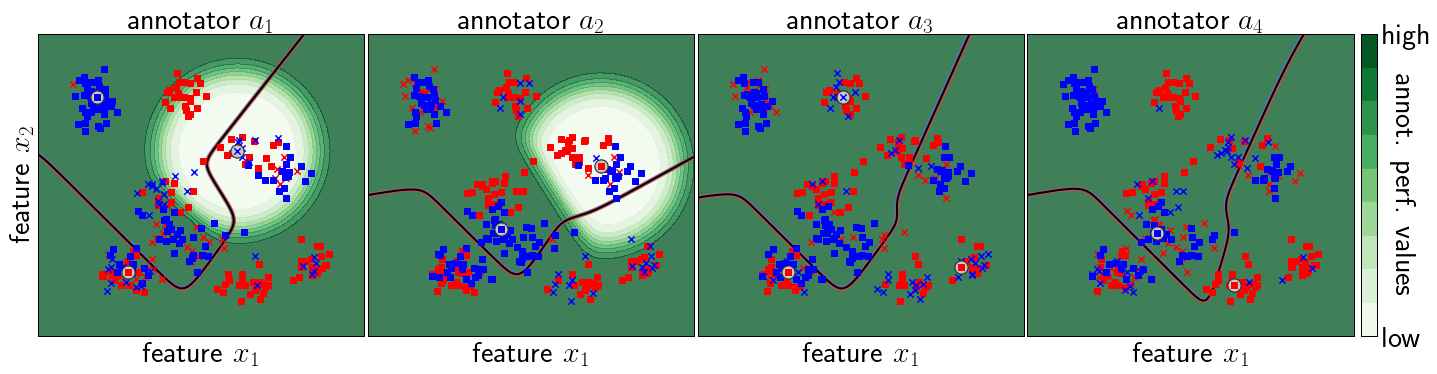

<Figure size 1728x864 with 0 Axes>

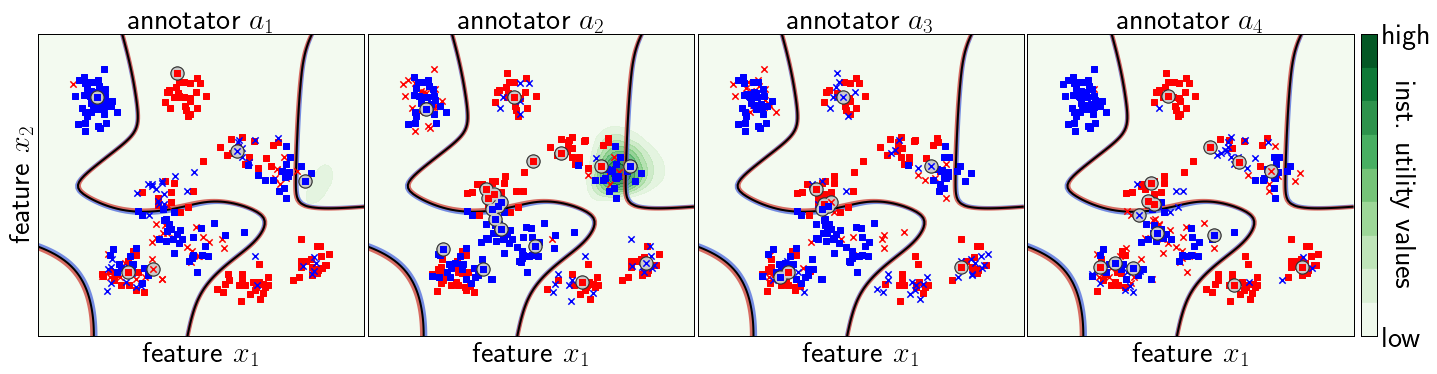

<Figure size 1728x864 with 0 Axes>

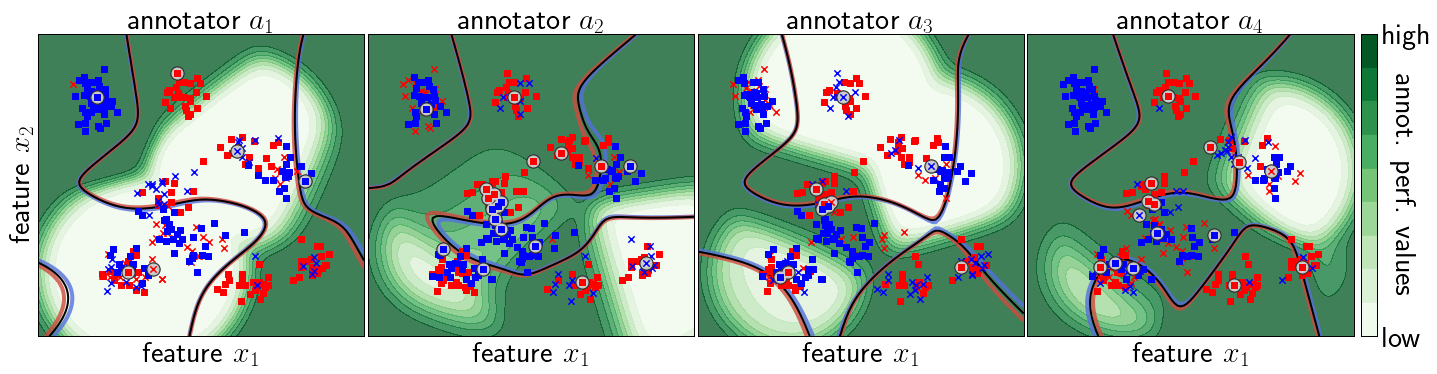

<Figure size 1728x864 with 0 Axes>

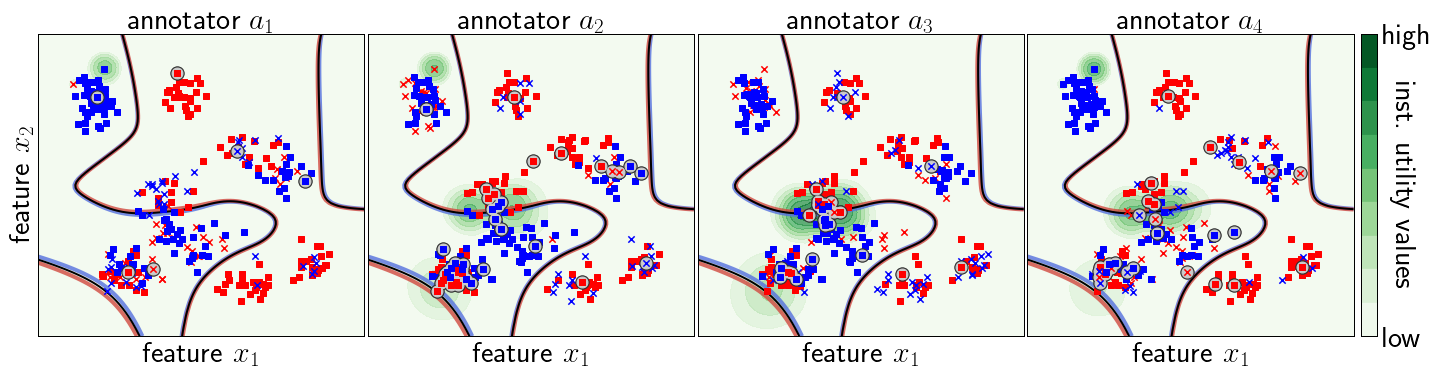

<Figure size 1728x864 with 0 Axes>

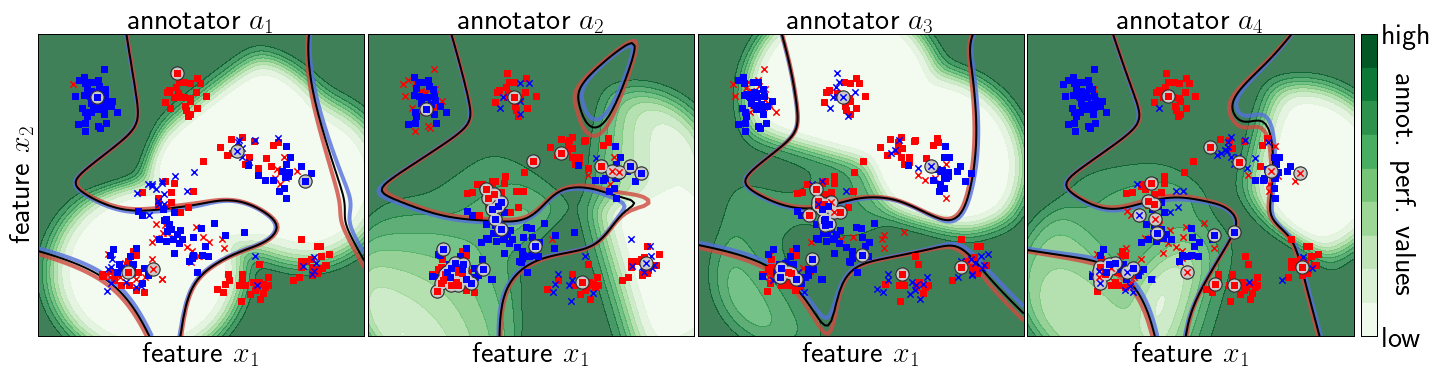

<Figure size 1728x864 with 0 Axes>

In [3]:
# plot setup
figsize = (24, 12)
fontsize = 30

# load data set
data_set_name = 'example-data-set-x'
X, y_true, y, X_1_mesh, X_2_mesh, mesh_instances, gamma = preprocess_2d_data_set(data_set_name=data_set_name)
n_samples = np.size(X, axis=0)
n_annotators = np.size(y, axis=1)
n_classes = np.size(np.unique(y_true), axis=0)

# parameter setup
prior_mean = 1.0
m_max = 1
beta_0 = 0.0001
alpha = 1
budgets = [10, 50, 100]

# execute learning cycle
data_set_list, prior = al_cylce(X=X, y=y, gamma=gamma, m_max=m_max, prior_mean=prior_mean, alpha=alpha, 
                                budgets=budgets, random_state=42, sum_prior=beta_0)

# precompute similarity matrices
S = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
S_mesh = pairwise_kernels(mesh_instances, X, metric='rbf', gamma=gamma)

for b, data_set in zip(budgets, data_set_list):
    # storages
    scores = []
    scores_bam = []
    P = []
    labeled = [data_set.get_labeled_indices(annotator_id=a) for a in range(data_set.n_annotators_)]
    unlabeled = [data_set.get_unlabeled_indices(annotator_id=a) for a in range(data_set.n_annotators_)]
    
    # fit bam and predict annotation performance values
    bam = BAM(n_classes=n_classes, metric='rbf', gamma=gamma, prior=prior, random_state=1)
    bam.fit(X=data_set.X_, y=data_set.y_)
    A = bam.predict_proba(mesh_instances).T
    A = A[0]
    
    # compute frequency estimates for evaluation set (K_x) and candidate set (K_c)
    Z = compute_vote_vectors(y=data_set.y_, c=data_set.c_, n_unique_votes=n_classes, probabilistic=False)
    K_x = S @ Z
    
    # compute probabilities of classification model
    P_a = S_mesh @ Z 
    P_a = P_a/np.sum(P_a, axis=1, keepdims=True)
    P_a = P_a[:, 0].reshape(X_1_mesh.shape)
    P_annnotators = []
    
    K_c = np.empty((data_set.n_annotators_, len(mesh_instances), n_classes))
    for a in range(data_set.n_annotators_):
        Z_a = compute_vote_vectors(y=data_set.y_[:, a], n_unique_votes=n_classes)
        K_c[a] = (S_mesh @ Z_a)
    
    # compute scores per annotator
    for a in range(n_annotators):
        scores_bam.append(A[:, a].reshape(X_1_mesh.shape))
        P.append(P_a)
        Z = compute_vote_vectors(y=data_set.y_[:, a],  n_unique_votes=n_classes)
        mask = list(range(n_annotators))
        mask.remove(a)
        Z_mask = compute_vote_vectors(y=data_set.y_[:, mask],  n_unique_votes=n_classes)
        P_z = (S_mesh @ Z_mask)
        P_z /= np.sum(P_z, axis=1, keepdims=True)
        P_z = P_z[:, 0].reshape(X_1_mesh.shape)
        P_annnotators.append(P_z)
        A_sample_a = A.copy()
        A_sample_a[:, a] = 100
        annotator_indices = np.argsort(-A_sample_a, axis=1)[:, :m_max]
        A_a = np.array([A[np.arange(len(mesh_instances)), annotator_indices[:, a]] for a in range(m_max)]).T
        K_c_a = np.array([K_c[annotator_indices[:, a], np.arange(len(mesh_instances))] for a in range(m_max)])
        scores_a = xpal_gain(K_c=K_c_a, K_x=K_x, S=S_mesh, A=A_a, alpha_x=alpha, alpha_c=alpha)
        scores.append(scores_a.reshape(X_1_mesh.shape))
    
    scores = np.array(scores)
    scores = (scores - np.min(scores))/(np.max(scores) - np.min(scores))
    
    # plot figures
    fig = plot_scores_2d(X=X, y_true=y_true, y=y, X_1_mesh=X_1_mesh, X_2_mesh=X_2_mesh, labeled_indices=labeled,
                         figsize=figsize, unlabeled_indices=unlabeled, scores=scores, vmin=scores.min(), vmax=scores.max(),
                         P=P, fontsize=fontsize,
                         filename='../../plots/mapal-m-{}-b-{}-beta_0-{}'.format(m_max, b, beta_0), cbar_label='inst. utility values')
    
    fig = plot_scores_2d(X=X, y_true=y_true, y=y, X_1_mesh=X_1_mesh, X_2_mesh=X_2_mesh, labeled_indices=labeled,
                         figsize=figsize, unlabeled_indices=unlabeled, scores=scores_bam, vmin=0, vmax=1,
                         P=P_annnotators, fontsize=fontsize, filename='../../plots/bam-m-{}-b-{}-beta_0-{}'.format(m_max, b, beta_0), cbar_label='annot. perf. values')

## Beta Annotator Model (BAM)

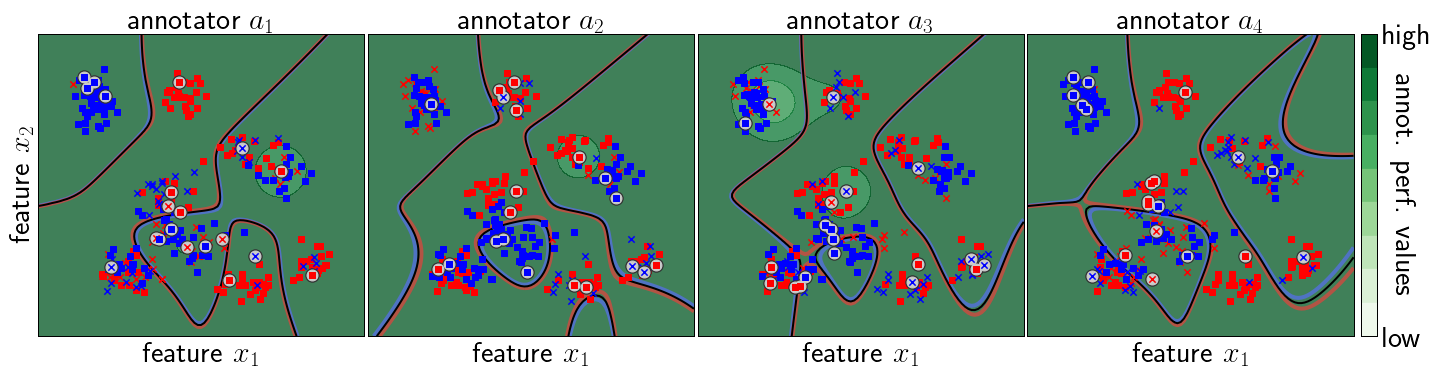

<Figure size 1728x864 with 0 Axes>

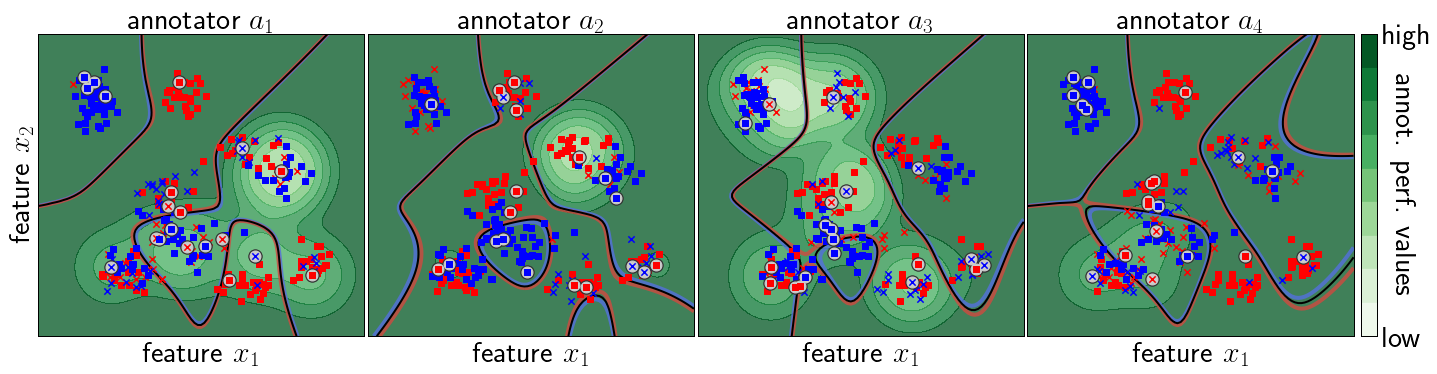

<Figure size 1728x864 with 0 Axes>

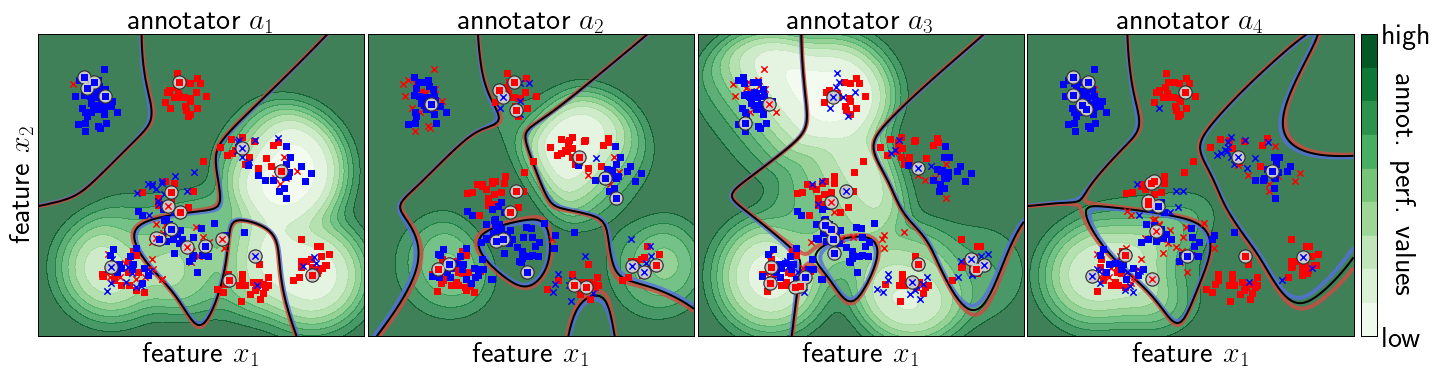

<Figure size 1728x864 with 0 Axes>

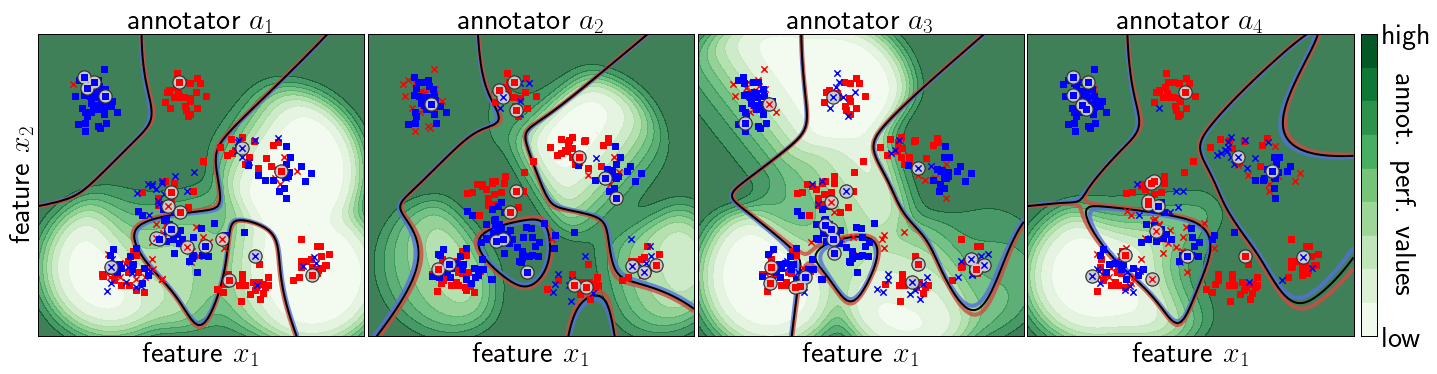

<Figure size 1728x864 with 0 Axes>

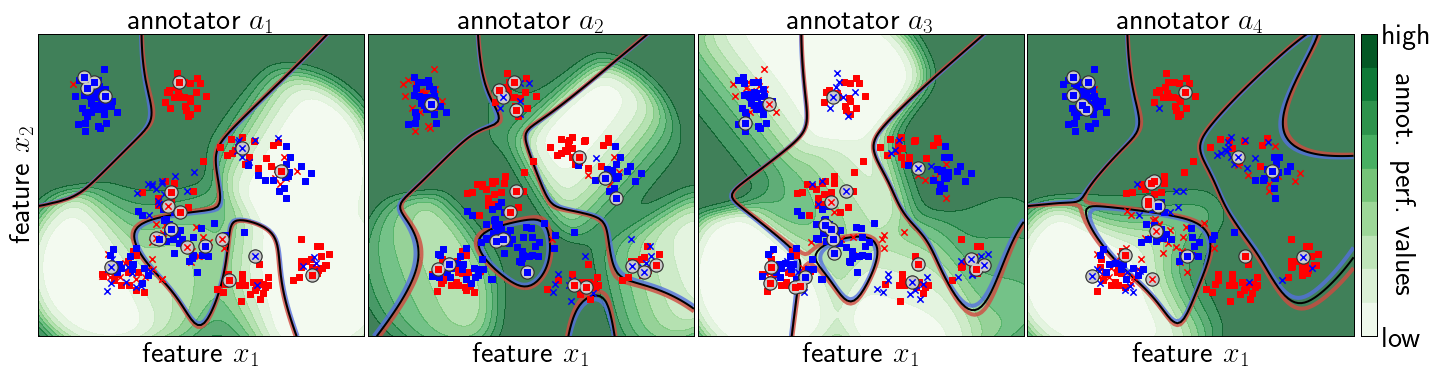

<Figure size 1728x864 with 0 Axes>

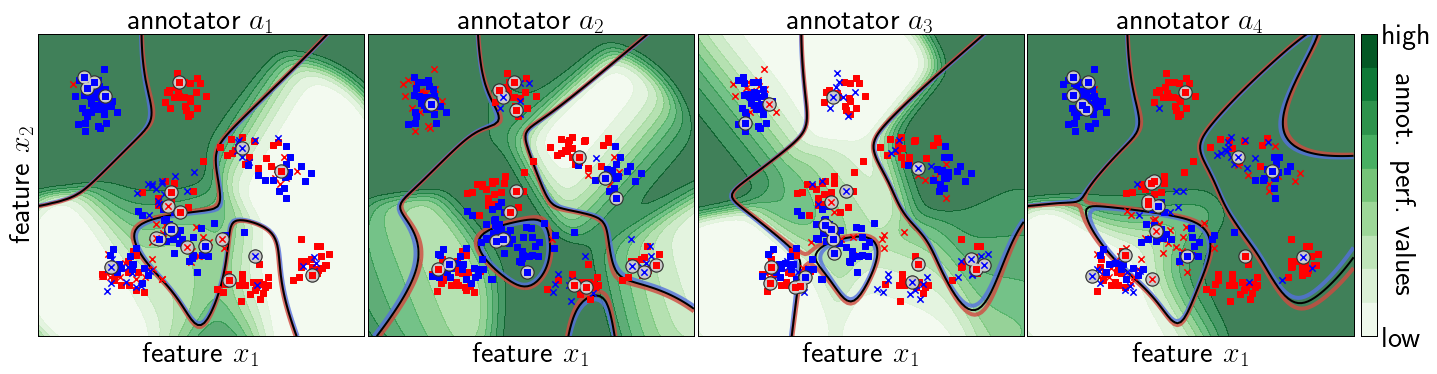

<Figure size 1728x864 with 0 Axes>

In [4]:
data_set_name = 'example-data-set-x'
figsize = (24, 12)
X, y_true, y, X_1_mesh, X_2_mesh, mesh_instances, gamma = preprocess_2d_data_set(data_set_name=data_set_name)
y_copy = np.full(y.shape, np.nan)
n_samples = len(X)
n_classes = len(np.unique(y_true))
n_annotators = y.shape[1]
S = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
S_mesh = pairwise_kernels(mesh_instances, X, metric='rbf', gamma=gamma)
sum_priors = {'1': 1.0, '0.1': 0.1, '0.01': 0.01, '0.001': 0.001, '0.0001': 0.0001, '0.00001': 0.00001}
prior_mean = 1
prior = np.array([prior_mean, 1 - prior_mean])

for sum_name, sum_prior in sum_priors.items():
    np.random.seed(0)
    prior_s = prior * sum_prior
    labeled = []
    unlabeled = []
    P = []
    for a in range(n_annotators):    
        unlabeled_indices = np.arange(len(X), dtype=int)
        labeled_indices = np.random.choice(unlabeled_indices, replace=False, size=20)
        np.delete(unlabeled_indices, labeled_indices)
        y_copy[labeled_indices, a] = y[labeled_indices, a]
        labeled.append(labeled_indices)
        unlabeled.append(unlabeled_indices)
        
        
    bam = BAM(n_classes=n_classes, metric='rbf', gamma=gamma, prior=prior_s, random_state=1)
    bam.fit(X=X, y=y_copy)
    scores_mesh = bam.predict_proba(mesh_instances).T[0]
    scores = []
    for a in range(n_annotators):
        scores.append(scores_mesh[:, a].reshape(X_1_mesh.shape))
        mask = list(range(n_annotators))
        mask.remove(a)
        Z = compute_vote_vectors(y=y_copy[:, mask],  n_unique_votes=n_classes)
        P_a = (S_mesh @ Z)
        P_a /= np.sum(P_a, axis=1, keepdims=True)
        P_a = P_a[:, 0].reshape(X_1_mesh.shape)
        P.append(P_a)
        
    
    fig = plot_scores_2d(X=X, y_true=y_true, y=y, X_1_mesh=X_1_mesh, X_2_mesh=X_2_mesh, labeled_indices=labeled,
                         figsize=figsize, unlabeled_indices=unlabeled, scores=scores, vmin=0, vmax=1,
                         P=P, fontsize=30, filename='../../plots/bam_{}'.format(sum_name), filetype='svg',
                         cbar_label='annot. perf. values')